<a href="https://colab.research.google.com/github/makxxic/NOTEBOOKS/blob/main/Stage5_Task_Starter_Breast_Cancer_Dataset_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Breast Cancer Dataset Classifier**

The following link https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data contains data that correlates the features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. It is used to classify the mass as either benign (B) or malignant (M).

You are required to implement a 3-layer neural network to classify a breast mass sample based on this dataset. Ensure each step of the process is properly documented using a text block in your notebook just before the code block. Implement in a Jupyter Notebook and submit the link below.



#### **Requirements:**

- Implement a 90% - 10% test train split. Ensure your data is well shuffled before splitting.
- Your neural network should have 2 hidden and 1 output layers.
- Use the ReLU activation for hidden layers and the sigmoid function for the output layer.
- Train your model with with SGD optimizer and choose an appropriate learning rate and criterion.
- Implement L2 regularization in your model to avoid overfitting.
- Your model must achieve 99% accuracy on the test dataset
- Implement early stopping to minimize computational resources
- At the end of the training print out the following:
  - Accuracy of the model on the validation data
  - Number of epochs to get to that accuracy
  - Criterion used

# 1. Imports
We start by importing the libraries we need.

- **pandas**: For handling tabular data.
- **numpy**: For numerical operations.
- **matplotlib**: For plotting graphs.
- **scikit-learn**: For preprocessing (scaling features, splitting data).
- **torch**: PyTorch library for building and training neural networks.


In [1]:
"""
Insert your imports here
"""
import kagglehub as kh
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.optim import SGD
import torch.optim as optim


# 2. Dataset Loading
We load the Breast Cancer Wisconsin dataset from Kaggle.

  
We need real-world data to train our model. This dataset contains features computed from breast cancer cell images, and the target is whether the tumor is **malignant (cancerous)** or **benign (non-cancerous)**.


In [2]:
"""
Download the breast dataset
"""
path = kh.dataset_download("uciml/breast-cancer-wisconsin-data")

df = pd.read_csv(path + "/data.csv")

df.head()

Using Colab cache for faster access to the 'breast-cancer-wisconsin-data' dataset.


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


#### Implement feature engineering

#3. Data Exploration
 We explore the dataset to understand:
 - What features are available - Whether there are missing values
 - The distribution of the target variable
 # Feature Engineering
We prepare the dataset for training:
- Convert target labels (M = malignant, B = benign) into binary values (1 and 0).
- Drop unnecessary columns (like ID).
- Scale features so they are on the same range (important for neural networks).


Neural networks work best when inputs are scaled and labels are numeric.



In [3]:


"""
Implement feature engineering on the data.
"""
df['diagnosis'].value_counts()# Count malignant vs benign cases
# Convert labels to binary, using replace for robustness
df['diagnosis'] = df['diagnosis'].replace({'M':1, 'B':0})

# Drop unnecessary columns, ignore if not found
df = df.drop(['id', 'Unnamed: 32'], axis=1, errors='ignore')

# Features
X = df.drop('diagnosis', axis=1).values
# Target
y = df['diagnosis'].values

# Handle potential NaNs in y before scaling or splitting
nan_mask = np.isnan(y)
if np.any(nan_mask):
    # Drop rows with NaN in diagnosis from both X and y
    X = X[~nan_mask]
    y = y[~nan_mask]
    print(f"Removed {np.sum(nan_mask)} rows with NaN values in 'diagnosis'.")



/tmp/ipython-input-3706361081.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['diagnosis'] = df['diagnosis'].replace({'M':1, 'B':0})


In [4]:
# Print the shape of the features and target to verify
print(f"Features shape: {X.shape}") # Should be (569, 30)
print(f"Target shape: {y.shape}")   # Should be (569,)

Features shape: (569, 30)
Target shape: (569,)


# 4. Train–Validation Split
We split the dataset into:
- **Training set (90%)**: Used to train the model.
- **Validation set (10%)**: Used to evaluate performance.

We must test our model on unseen data to check if it generalizes well.


In [5]:
"""
Split processed dataframe into test and validation sets.
"""
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.1,
    shuffle=True,
    random_state=42,
    stratify=y
)

In [6]:
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

Training samples: 512
Validation samples: 57


In [7]:
# Initialize scaler and scale features
scaler = StandardScaler()

# Fit the scaler on the TRAINING data only, then transform the training data
# We do not fit on validation data to prevent "data leakage" (cheating)
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation data using the stats learned from the training data
X_val_scaled = scaler.transform(X_val)

# 5. Tensor Conversion
We convert numpy arrays into PyTorch tensors.


PyTorch models only work with tensors, which are its special data structure for numerical computation.


In [8]:
"""
Get the PyTorch tensors
"""
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# 6. Neural Network Architecture
We build a neural network with:
- Input layer (30 features)
- 2 hidden layers (ReLU activation)
- Output layer (Sigmoid activation for binary classification)

Neural networks learn complex patterns in data. ReLU helps hidden layers learn non-linear relationships, and Sigmoid outputs probabilities between 0 and 1.


In [9]:
"""
Implement your neural network architecture here
"""

# Define neural network using Sequential container
model = nn.Sequential(
    nn.Linear(30, 16),   # First hidden layer (30 -> 16)
    nn.ReLU(),           # ReLU activation
    nn.Linear(16, 8),    # Second hidden layer (16 -> 8)
    nn.ReLU(),           # ReLU activation
    nn.Linear(8, 1),     # Output layer (8 -> 1)
    nn.Sigmoid()         # Sigmoid activation for probability output
)


# 7. Hyperparameters and Loss
We define:
- **Learning rate**: Step size for optimization (0.01 is a safe choice for SGD).
- **Optimizer**: Stochastic Gradient Descent (SGD) with L2 regularization (weight decay).
- **Loss function**: Binary Cross Entropy (BCE) for binary classification.

The optimizer updates weights, the loss function measures error, and hyperparameters control training speed and stability.


In [10]:
"""
Define hyperparameters
"""
learning_rate = 0.001
# Loss Function: Binary Cross Entropy Loss
# Used specifically for binary classification (0 or 1)
criterion = nn.BCELoss() # Binary Cross Entropy loss
# Optimizer: Stochastic Gradient Descent (SGD)
# lr: learning rate
# weight_decay: L2 Regularization (0.001) helps prevent overfitting
optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, weight_decay=0.001)

print(f"Optimizer: SGD, Loss: BCELoss, LR: {learning_rate}")

Optimizer: SGD, Loss: BCELoss, LR: 0.001


# 8. Training Loop with Early Stopping
We train the model:
- Forward pass: Compute predictions
- Loss calculation: Compare predictions with true labels
- Backward pass: Update weights using optimizer
- Early stopping: Stop training if validation loss does not improve for several epochs

Early stopping prevents overfitting and saves time by halting training when the model stops improving.


In [11]:
epochs = 1000            # Maximum number of epochs
patience = 20             # Patience for early stopping
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in range(epochs):
    # --- Training phase ---
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Calculate training accuracy
    train_preds = (outputs > 0.5).float()
    train_acc = (train_preds == y_train_tensor).sum().item() / float(y_train_tensor.shape[0])
    train_accuracy.append(train_acc)

    # --- Validation phase ---
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_tensor)
        val_loss = criterion(y_val_pred, y_val_tensor)
        y_val_pred_class = (y_val_pred > 0.5).float()
        val_acc = (y_val_pred_class == y_val_tensor).sum().item() / float(y_val_tensor.shape[0])
        val_accuracy.append(val_acc)
        val_losses.append(val_loss.item())

    # Print progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, '
              f'Val Loss: {val_loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    # --- Early stopping check ---
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_accuracy = val_acc
        best_epoch = epoch + 1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}!")
        break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))


Epoch [50/1000], Train Loss: 0.6467, Val Loss: 0.6455, Train Acc: 0.6602, Val Acc: 0.6316
Epoch [100/1000], Train Loss: 0.6074, Val Loss: 0.6071, Train Acc: 0.7656, Val Acc: 0.7544
Epoch [150/1000], Train Loss: 0.5552, Val Loss: 0.5565, Train Acc: 0.8672, Val Acc: 0.8947
Epoch [200/1000], Train Loss: 0.4902, Val Loss: 0.4914, Train Acc: 0.9199, Val Acc: 0.9298
Epoch [250/1000], Train Loss: 0.4175, Val Loss: 0.4169, Train Acc: 0.9375, Val Acc: 0.9474
Epoch [300/1000], Train Loss: 0.3476, Val Loss: 0.3441, Train Acc: 0.9434, Val Acc: 0.9474
Epoch [350/1000], Train Loss: 0.2872, Val Loss: 0.2797, Train Acc: 0.9492, Val Acc: 0.9474
Epoch [400/1000], Train Loss: 0.2389, Val Loss: 0.2274, Train Acc: 0.9512, Val Acc: 0.9474
Epoch [450/1000], Train Loss: 0.2027, Val Loss: 0.1876, Train Acc: 0.9512, Val Acc: 0.9825
Epoch [500/1000], Train Loss: 0.1762, Val Loss: 0.1579, Train Acc: 0.9512, Val Acc: 0.9825
Epoch [550/1000], Train Loss: 0.1567, Val Loss: 0.1358, Train Acc: 0.9531, Val Acc: 1.0000


<All keys matched successfully>

# 9. Loss Plot
We plot training loss vs epochs.

Visualizing loss helps us understand whether the model is learning properly and when it starts overfitting.


In [12]:
def plot_losses(plt, title, train_losses, val_losses, label):
    plt.plot(train_losses, label=f"Train {label}")
    plt.plot(val_losses, label=f"Validation {label}")
    plt.legend()
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(label)

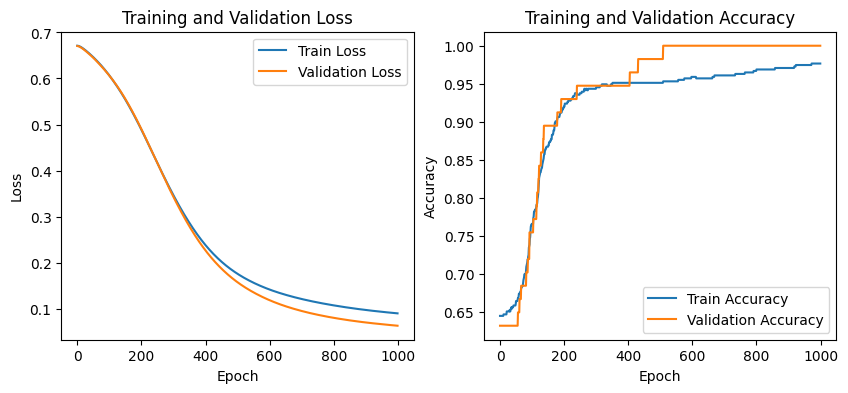

In [13]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_losses(plt, "Training and Validation Loss", train_losses, val_losses, label="Loss")
plt.subplot(1, 2, 2)
plot_losses(plt, "Training and Validation Accuracy", train_accuracy, val_accuracy, label="Accuracy")
plt.show()

# 10. Final Evaluation
We evaluate the model on the validation set:
- Compute predictions
- Convert probabilities to binary labels (0 or 1)
- Calculate accuracy
- Print final results


In [14]:
"""
At the end of the training print out the following:
    - Accuracy of the model on the validation data
    - Number of epochs to get to that accuracy
    - Criterion used
"""
model.eval()
with torch.no_grad():
    val_probs = model(X_val_tensor)
    val_preds = (val_probs >= 0.5).float()
    correct = (val_preds == y_val_tensor).sum().item()
    total = y_val_tensor.size(0)
    accuracy = correct / total * 100

print("Validation Accuracy: {:.2f}%".format(accuracy))
print("Epochs to reach best accuracy:", best_epoch)
print("Criterion used:", criterion.__class__.__name__)


Validation Accuracy: 100.00%
Epochs to reach best accuracy: 1000
Criterion used: BCELoss
